In [22]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import os
import numpy as np
from matplotlib import pyplot as plt

In [2]:
!pip install torchtext
!python -m spacy download en

     |████████████████████████████████| 12.0 MB 4.4 MB/s 
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')
✔ Linking successful
/usr/local/lib/python3.7/dist-packages/en_core_web_sm -->
/usr/local/lib/python3.7/dist-packages/spacy/data/en
You can now load the model via spacy.load('en')


In [3]:
import torch
from torchtext.legacy import data

SEED = 1234

torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

TEXT = data.Field(tokenize='spacy')
LABEL = data.LabelField(dtype=torch.float)

In [4]:
from torchtext.legacy import datasets
train_data, test_data = datasets.IMDB.splits(TEXT, LABEL, root="./data")

downloading aclImdb_v1.tar.gz


100%|██████████| 84.1M/84.1M [00:09<00:00, 8.75MB/s]


In [5]:
print(f'Number of training examples: {len(train_data)}')
print(f'Number of testing examples: {len(test_data)}')

Number of training examples: 25000
Number of testing examples: 25000


In [6]:
print(vars(train_data.examples[0]))

{'text': ['Emilio', 'Miraglio', "'s", '"', 'The', 'Red', 'Queen', 'Kills', 'Seven', 'Times', '"', '(', '1972', ')', 'is', 'just', 'about', 'the', 'most', 'perfect', 'example', 'of', 'a', 'giallo', 'that', 'I', 'have', 'ever', 'seen', ',', 'mixing', 'all', 'the', 'requisite', 'elements', 'into', 'one', 'sinister', 'stew', 'indeed', '.', 'First', 'of', 'all', ',', 'and', 'of', 'paramount', 'importance', 'for', 'me', ',', 'it', 'has', 'a', 'complex', ',', 'twisty', 'plot', 'that', 'ultimately', 'makes', 'perfect', 'sense', ',', 'and', 'the', 'killer', 'here', 'does', 'not', 'come', 'completely', 'out', 'of', 'left', 'field', 'at', 'the', 'end', '.', 'The', 'story', ',', 'concerning', 'a', 'series', 'of', 'gruesome', 'murders', '(', 'you', 'already', 'know', 'how', 'many', 'from', 'the', 'film', "'s", 'title', ',', 'right', '?', ')', 'that', 'takes', 'place', 'in', 'seeming', 'fulfillment', 'of', 'an', 'ancient', 'prophecy', 'concerning', 'two', 'sisters', ',', 'is', 'an', 'involving', 'on

In [7]:
import random

train_data, valid_data = train_data.split(random_state=random.seed(SEED))

In [8]:
#create dictionary
TEXT.build_vocab(train_data, max_size=25000)
LABEL.build_vocab(train_data)

In [9]:
print(f"Unique tokens in TEXT vocabulary: {len(TEXT.vocab)}")
print(f"Unique tokens in LABEL vocabulary: {len(LABEL.vocab)}")

Unique tokens in TEXT vocabulary: 25002
Unique tokens in LABEL vocabulary: 2


In [10]:
vars(LABEL.vocab)

{'freqs': Counter({'neg': 8810, 'pos': 8690}),
 'itos': ['neg', 'pos'],
 'stoi': defaultdict(None, {'neg': 0, 'pos': 1}),
 'unk_index': None,
 'vectors': None}

In [11]:
print(TEXT.vocab.freqs.most_common(20))

[('the', 203672), (',', 193693), ('.', 166634), ('a', 109927), ('and', 109350), ('of', 101241), ('to', 94274), ('is', 76710), ('in', 61284), ('I', 54630), ('it', 53894), ('that', 49323), ('"', 44747), ("'s", 43545), ('this', 42543), ('-', 37119), ('/><br', 36166), ('was', 35143), ('as', 30566), ('with', 30059)]


* stoi (string to int)
* itos (int to string)

In [12]:
BATCH_SIZE = 64

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_iterator, valid_iterator, test_iterator = data.BucketIterator.splits(
    (train_data, valid_data, test_data), 
    batch_size=BATCH_SIZE,
    device=device)

## Делаем модель

In [13]:
def accuracy(input, target):
    max_input = torch.max(input, 1)
    max_target = torch.max(target, 1)
    corrects = (max_input.indices == max_target.indices).sum()
    accuracy = 100.0 * corrects/input.shape[0]
    return accuracy.item()

In [14]:
class RNN(nn.Module):
    def __init__(self, input_dim, embedding_dim, hidden_dim, output_dim):
        super().__init__()

        self.input_dim = input_dim
        self.embedding_dim = embedding_dim
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim

        self.embedding = nn.Embedding(self.input_dim, self.embedding_dim)
        self.rnn = nn.RNN(self.embedding_dim, self.hidden_dim, 1)
        self.fc = nn.Linear(self.hidden_dim, self.output_dim)
        self.sig = nn.Softmax(dim=1)

    def forward(self, X, hidden):
        embedded =  self.embedding(X)
        output, hidden = self.rnn(embedded, hidden)
        output = self.fc(output)

        return self.sig(output), hidden

    def init_hidden(self, input):
        self.batch_size = input.shape[1]
        return torch.zeros(1, self.batch_size, self.hidden_dim)

In [27]:
input_dim = 25002
embedding_dim = 200
hidden_dim = 50 
output_dim = 2
n_epochs = 3
learning_rate = 10**(-5)

In [17]:
import torch.optim as optim

# Device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Model instance
model = RNN(input_dim, embedding_dim, hidden_dim, output_dim)
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [28]:
model.train()
history = []

for epoch in range(n_epochs):
    iter = 0
    train_acc = 0.0
    for x in train_iterator:
        iter += 1
        optimizer.zero_grad()
        inputs = x.text
        labels = x.label
        hidden = model.init_hidden(inputs)
        outputs, hidden = model(inputs, hidden)
        outputs = outputs.sum(0)

        labels_1 = 1 - labels
        labels = torch.cat((labels, labels_1), 0).reshape(2,labels.shape[0]).T

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        history.append(loss.item())
        train_acc += accuracy(outputs, labels)
    
    print('Epoch:  %d | Loss: %.4f' %(epoch, torch.FloatTensor(history[-5:]).mean()))
    print('Train Accuracy: ', train_acc/iter)

Epoch:  0 | Loss: 0.2743
Train Accuracy:  86.73830160433359
Epoch:  1 | Loss: 0.2860
Train Accuracy:  87.834006789827
Epoch:  2 | Loss: 0.3078
Train Accuracy:  88.46780501316934


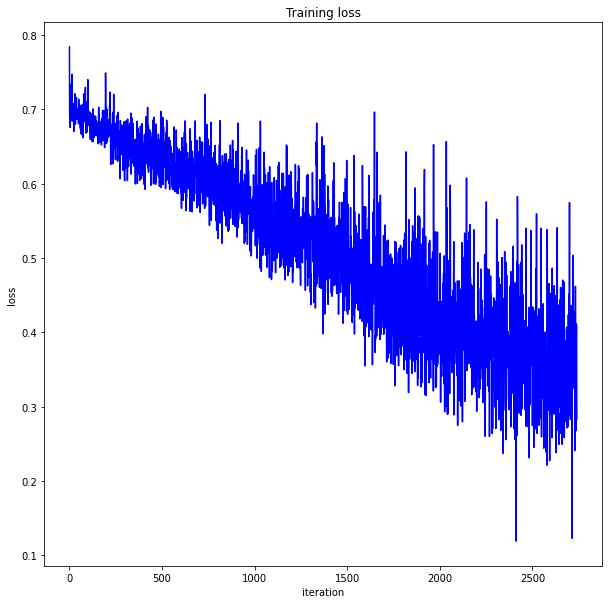

In [23]:
plt.figure(figsize=(10, 10))
plt.title("Training loss")
plt.xlabel("iteration")
plt.ylabel("loss")
plt.plot(history, 'b')
plt.show()

In [29]:
test_acc = 0.0
iter = 0

model.eval()

for x in test_iterator:
    iter = iter + 1
    inputs = x.text
    labels = x.label
    hidden = model.init_hidden(inputs)
    outputs, hidden = model(inputs, hidden)
    outputs = outputs.sum(0)
    labels_1 = 1 - labels
    labels = torch.cat((labels, labels_1), 0).reshape(2,labels.shape[0]).T

    test_acc += accuracy(outputs, labels)

print('Test Accuracy: %.2f'%( test_acc/iter))

Test Accuracy: 78.95
